In [144]:
#importowanie bibliotek
from tkinter import OptionMenu
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from tkinter import StringVar
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import random
import math
from tokenize import String

In [145]:
# Wczywanie danych z pliku
def read_tsp_file(filename):
    with open(file=filename) as f:
        lines =f.readlines()
    my_nodes= []
    for line in lines[6:-3]:
        line =line.strip().split()
        my_nodes.append((float(line[1]),float(line[2])))
    return np.array(my_nodes)

In [146]:
# Obliczanie macierzy odleglosci
def distance_matrix(coords):
    n = len(coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = math.sqrt((coords[j][0]-coords[i][0])**2+(coords[j][1]-coords[i][1])**2)
    return dist_matrix

In [147]:
# Algorytm mrowkowy 

class AntSystem:
    #Inicjalizacja zmiennych
    def __init__(self, coords, num_ants, alpha, beta, rho, q, num_iterations):
        self.coords = coords
        self.num_ants = num_ants 
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.num_iterations = num_iterations
        self.num_nodes = len(coords)
        self.dist_matrix = distance_matrix(coords)
        self.pheromone_matrix = np.ones((self.num_nodes, self.num_nodes))
        self.best_path = None
        self.best_path_length = 99999999

    # Glowna funkcja uruchamiająca algorytm
    def run(self):
        for i in range(self.num_iterations):
            all_paths = self.construct_all_solutions()
            self.update_pheromones(all_paths)
            self.update_best_path(all_paths)
            
    # Skonstrowanie rozwiązan dla wszystkich mrowek
    def construct_all_solutions(self):
        all_paths = []
        for ant in range(self.num_ants):
            path = self.construct_solution()
            all_paths.append((path, self.calculate_path_length(path)))
        return all_paths

    # Skonstrowanie rozwiązan dla jednej mrówki
    def construct_solution(self):
        path = [random.randint(0, self.num_nodes - 1)]
        while len(path) < self.num_nodes:
            next_node = self.select_next_node(path)
            path.append(next_node)
        return path
    
    #Wybór następnego węzła do odwiedzenia na podstawie feromonu i odległości
    def select_next_node(self, path):
        current_node = path[-1]
        unvisited_nodes = set(range(self.num_nodes)) - set(path)
        probabilities = []
        for node in unvisited_nodes:
            prob = (self.pheromone_matrix[current_node][node] ** self.alpha) * ((1 / self.dist_matrix[current_node][node]) ** self.beta)      
            probabilities.append((node, prob))
        total_prob = sum(prob for _, prob in probabilities)
        probabilities = [(node, prob / total_prob) for node, prob in probabilities]
        r = random.random()
        cumulative_prob = 0
        for node, prob in probabilities:
            cumulative_prob += prob
            if r <= cumulative_prob:
                return node
            
    # Oblicz długość danej ścieżki
    def calculate_path_length(self, path):
        length = 0
        for i in range(len(path) - 1):
            length += self.dist_matrix[path[i]][path[i + 1]]
        length += self.dist_matrix[path[-1]][path[0]]
        return length

    # Aktualizuje poziomy feromonów na podstawie wszystkich skonstruowanych ścieżek.
    def update_pheromones(self, all_paths):
        self.pheromone_matrix *= (1 - self.rho)
        for path, length in all_paths:
            for i in range(len(path) - 1):
                self.pheromone_matrix[path[i]][path[i + 1]] += self.q / length
            self.pheromone_matrix[path[-1]][path[0]] += self.q / length
            
    # Aktualizuje najlepszą ścieżkę znalezioną na podstawie wszystkich skonstruowanych ścieżek.
    def update_best_path(self, all_paths):
        for path, length in all_paths:
            if length < self.best_path_length:
                self.best_path_length = length
                self.best_path = path

In [148]:
#Interfejs graficzny

class AntColonyGUI:
    #Inicjalizacja zmiennych
    def __init__(self, root, coords):
        self.root = root
        self.coords = coords
        self.num_ants = tk.IntVar(value=30)
        self.alpha = tk.DoubleVar(value=1.0)
        self.beta = tk.DoubleVar(value=3.0)
        self.rho = tk.DoubleVar(value=0.1)
        self.q = tk.DoubleVar(value=1.0)
        self.num_iterations = tk.IntVar(value=300)
        self.setup_gui()
        
    # Funkcja konfiguracji komponentów GUI
    def setup_gui(self):
        self.root.title("ACO - Piotr Katolik 162100")
        
        frame = ttk.Frame(self.root, padding="10")
        frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        ttk.Label(frame, text="Ants:").grid(row=0, column=0, sticky=tk.W)
        ttk.Entry(frame, textvariable=self.num_ants).grid(row=0, column=1, sticky=tk.E)
        
        ttk.Label(frame, text="\u03B1:").grid(row=1, column=0, sticky=tk.W)
        ttk.Entry(frame, textvariable=self.alpha).grid(row=1, column=1, sticky=tk.E)
        
        ttk.Label(frame, text="\u03B2:").grid(row=2, column=0, sticky=tk.W)
        ttk.Entry(frame, textvariable=self.beta).grid(row=2, column=1, sticky=tk.E)
        
        ttk.Label(frame, text="\u03C1:").grid(row=3, column=0, sticky=tk.W)
        ttk.Entry(frame, textvariable=self.rho).grid(row=3, column=1, sticky=tk.E)
        
        ttk.Label(frame, text="Q:").grid(row=4, column=0, sticky=tk.W)
        ttk.Entry(frame, textvariable=self.q).grid(row=4, column=1, sticky=tk.E)
        
        ttk.Label(frame, text="Number of Iterations:").grid(row=5, column=0, sticky=tk.W)
        ttk.Entry(frame, textvariable=self.num_iterations).grid(row=5, column=1, sticky=tk.E)
        
        # Funkcja zmiany współrzędnych na podstawie wybranego pliku TSP
        def filechange(data_name):
            self.coords = read_tsp_file(data_name)
            
        # Rozwijane menu wyboru pliku TSP
        data_name = StringVar(frame)
        data_name.set("ulysses22.tsp") # Ustawienie wortości domyślnej

        OptionMenu(frame, data_name, "ulysses22.tsp", "berlin52.tsp", "eil101.tsp",command=filechange).grid(row=6, column=0, columnspan=2, sticky=tk.W+tk.E) 
                      
        ttk.Button(frame, text="Run", command=self.run_algorithm).grid(row=7, column=0, columnspan=2)
        
        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas.get_tk_widget().grid(row=1, column=0)
        self.ax.set_title("Best path length: ")
        
    # Przycisk Run do uruchomienia algorytmu
    def run_algorithm(self):
                     
        self.ax.clear()
        self.ax.plot(self.coords[:, 0], self.coords[:, 1], 'ro')
        
        # Inicjalizacja algorytmu z bieżącymi wartościami
        self.ant_system = AntSystem(
            self.coords, 
            self.num_ants.get(), 
            self.alpha.get(), 
            self.beta.get(), 
            self.rho.get(), 
            self.q.get(), 
            self.num_iterations.get()
        )
        self.ant_system.run()
        
        txt=str(round(self.ant_system.best_path_length,4))
        self.ax.set_title("Best path length: " + txt)

        best_path = self.ant_system.best_path
        best_coords = np.array([self.coords[i] for i in best_path] + [self.coords[best_path[0]]])
        self.ax.plot(best_coords[:, 0], best_coords[:, 1], 'b-')
                   
        self.canvas.draw()

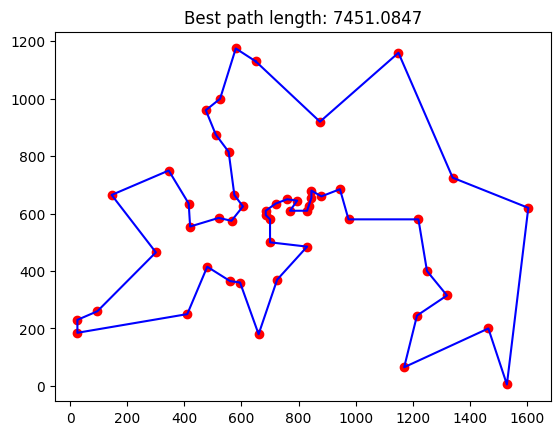

In [149]:
#Główna pętla działania programu
root = tk.Tk()
coords = read_tsp_file("ulysses22.tsp")
gui = AntColonyGUI(root,coords)
root.mainloop()